In [1]:
###Hide
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import grid_search
from sklearn.decomposition import PCA
from sklearn import feature_selection as fs
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Tuning to Maximize Model Performance

#### Step 2.1: Get Performance Metric

In [2]:
# Load the performance metric
performance_metric = pd.read_csv('datasets/performance_metric.csv', delimiter=',')

print "Our Performance Metric is to get a better score the following:"
performance_metric

Our Performance Metric is to get a better score the following:


,KNN,LDA,QDA,RF,SVC,Tree,Unweighted Logistic,Weighted Logistic
0,0.905711,0.906115,0.847791,0.791891,0.760776,0.896013,0.908675,0.648303
1,0.990794,0.990943,0.911210,0.843207,0.794655,0.974759,0.997327,0.657313
2,0.074020,0.076923,0.227866,0.290276,0.429608,0.126270,0.042090,0.560232


#### Step 2.2: Select Top Performing Models

Pick the top 3 top performing models whos accuracy score is high in both classes. From the metric table we can see that Weighted Logistic, SVC, and Random Forest performs the best. So let take them as the base model and work towards tuning them to get better results.

#### Step 2.3: Tune Selected Model

In [11]:
# Load the clean data
ncds_data_no_indicators = pd.read_csv('datasets/ncds_data_no_indicators.csv', delimiter=',', low_memory=False)

In [12]:
# Function for computing the accuracy a given model on the entire test set,
# the accuracy on class 0 in the test set
# and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])


In [9]:
# Best features
def get_best_feature(num_of_features,df,x_train, y_train):
    features = fs.SelectKBest(fs.f_regression, k=num_of_features) #k is number of features.
    features.fit(x_train, y_train)

    selected_features = features.get_support()
    selected_features_columns =  df.columns[selected_features].values
    return selected_features_columns


##### Weighted Logistic Regression Model Tuning

Tuning params without standardization of predictors:


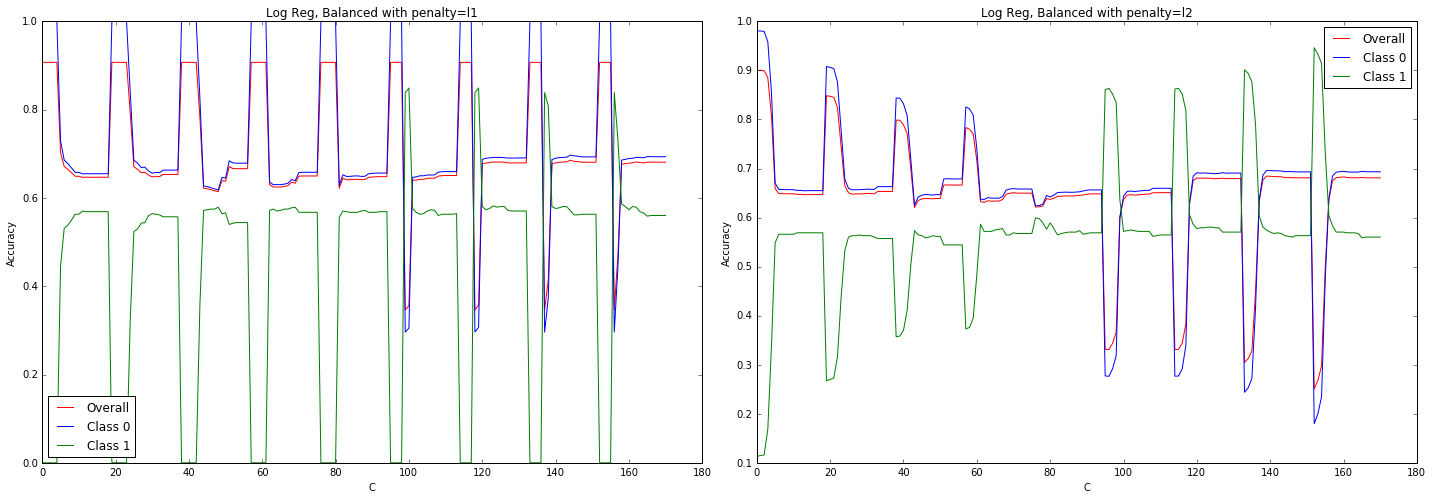

In [21]:
### Logistic Model Tuning

def tune_logistic_reg_model():
    #c_list = [0.00000001,0.0000001,0.000001,0.00001,0.0001, 0.001,0.01,0.015,0.02,0.03,0.04,0.08]
    c_list = [0.00000001,0.0000001,0.000001,0.00001,0.0001, 0.001,0.01,0.015,0.02,0.03,0.04,0.08,0.1,1,10,100,10000,100000,1000000]
    l1_overall = []
    l1_class_0 = []
    l1_class_1 = []
    l2_overall = []
    l2_class_0 = []
    l2_class_1 = []
    no_of_features = [10,15,20,25,30,35,40,45,50]
    x_index =[]
    count = 0
    x_l1_df = pd.DataFrame(columns=('x_index', 'C', 'NOF', 'class0', 'class1','overall'))
    x_l2_df = pd.DataFrame(columns=('x_index', 'C', 'NOF', 'class0', 'class1','overall'))
    
    for nof in no_of_features:
        # Split data for all features
        x = ncds_data_no_indicators.values[:, :-1]
        y = ncds_data_no_indicators.values[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
    
    
        # Get best features
        selected_features_columns = get_best_feature(nof,ncds_data_no_indicators,x_train, y_train)

        # Split data for selected features only
        x = ncds_data_no_indicators[selected_features_columns].values[:,:]
        y = ncds_data_no_indicators.values[:, -1]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

        for c in c_list:
            x_index.append(count)
            
            logistic = LogisticRegression(class_weight='balanced',C=c,penalty='l1')
            logistic.fit(x_train, y_train)
            logistic_scores = score(logistic, x_test, y_test)
            #print logistic_scores
            l1_overall.append(logistic_scores['overall accuracy'])
            l1_class_0.append(logistic_scores['accuracy on class 0'])
            l1_class_1.append(logistic_scores['accuracy on class 1'])
            
            x_l1_df.loc[count] = {'x_index':count, 'C':c, 'NOF':nof , 'class0':logistic_scores['accuracy on class 0'], 'class1':logistic_scores['accuracy on class 1'],'overall':logistic_scores['overall accuracy']}

            logistic = LogisticRegression(class_weight='balanced',C=c,penalty='l2')
            logistic.fit(x_train, y_train)
            logistic_scores = score(logistic, x_test, y_test)
            #print logistic_scores
            l2_overall.append(logistic_scores['overall accuracy'])
            l2_class_0.append(logistic_scores['accuracy on class 0'])
            l2_class_1.append(logistic_scores['accuracy on class 1'])
            
            
            
            x_l2_df.loc[count] = {'x_index':count, 'C':c, 'NOF':nof , 'class0':logistic_scores['accuracy on class 0'], 'class1':logistic_scores['accuracy on class 1'],'overall':logistic_scores['overall accuracy']}
            count = count +1


    #best_l1_class_1_accuracy = np.argmax(l1_class_1)
    #best_l2_class_1_accuracy = np.argmax(l2_class_1)
    #print "Best Class 1 accuracy is for L1 and C: " , c_list[best_l1_class_1_accuracy] , " Class 1: ",round(l1_class_1[best_l1_class_1_accuracy],5) , " Class 0: ",round(l1_class_0[best_l1_class_1_accuracy],5)
    #print "Best Class 1 accuracy is for L2 and C: " , c_list[best_l2_class_1_accuracy] , " Class 1: ",round(l2_class_1[best_l2_class_1_accuracy],5) , " Class 0: ",round(l2_class_0[best_l2_class_1_accuracy],5)

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].plot(x_index,l1_overall,color='r',label='Overall')
    ax[0].plot(x_index,l1_class_0,color='b',label='Class 0')
    ax[0].plot(x_index,l1_class_1,color='g',label='Class 1')
    ax[0].set_title("Log Reg, Balanced with penalty=l1")
    ax[0].set_xlabel('C')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc = 'best')

    ax[1].plot(x_index,l2_overall,color='r',label='Overall')
    ax[1].plot(x_index,l2_class_0,color='b',label='Class 0')
    ax[1].plot(x_index,l2_class_1,color='g',label='Class 1')
    ax[1].set_title("Log Reg, Balanced with penalty=l2")
    ax[1].set_xlabel('C')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc = 'best')

    plt.tight_layout()
    plt.show()
    
    return x_l1_df , x_l2_df


# Tune without standarization
print "Tuning params without standardization of predictors:"
tune_params_l1 , tune_params_l2 = tune_logistic_reg_model()

In [23]:
# Logistic with l1 penalty
tune_params_l1['sum'] = tune_params_l1['class0'] + tune_params_l1['class1']
tune_params_l1.sort_values(['sum'], ascending=[False]).head(10)

,x_index,C,NOF,class0,class1,overall,sum
123,123.0,0.03,40.0,0.691759,0.582003,0.681573,1.273762
143,143.0,0.04,45.0,0.692205,0.580552,0.681843,1.272756
125,125.0,0.08,40.0,0.691908,0.580552,0.681573,1.272459
142,142.0,0.03,45.0,0.691759,0.580552,0.681439,1.272311
158,158.0,0.01,50.0,0.685820,0.586357,0.676589,1.272177
126,126.0,0.10,40.0,0.691166,0.580552,0.680900,1.271717
162,162.0,0.04,50.0,0.692056,0.579100,0.681573,1.271157
124,124.0,0.04,40.0,0.691759,0.579100,0.681304,1.270860
161,161.0,0.03,50.0,0.689829,0.580552,0.679688,1.270381
141,141.0,0.02,45.0,0.691463,0.577649,0.680900,1.269111


In [24]:
# Logistic with l2 penalty
tune_params_l2['sum'] = tune_params_l1['class0'] + tune_params_l1['class1']
tune_params_l2.sort_values(['sum'], ascending=[False]).head(10)

,x_index,C,NOF,class0,class1,overall,sum
123,123.0,0.03,40.0,0.690572,0.580552,0.680361,1.273762
143,143.0,0.04,45.0,0.695026,0.567489,0.683190,1.272756
125,125.0,0.08,40.0,0.689532,0.579100,0.679283,1.272459
142,142.0,0.03,45.0,0.695026,0.568940,0.683324,1.272311
158,158.0,0.01,50.0,0.692650,0.570392,0.681304,1.272177
126,126.0,0.10,40.0,0.689978,0.579100,0.679688,1.271717
162,162.0,0.04,50.0,0.692650,0.568940,0.681169,1.271157
124,124.0,0.04,40.0,0.689978,0.580552,0.679822,1.270860
161,161.0,0.03,50.0,0.693244,0.568940,0.681708,1.270381
141,141.0,0.02,45.0,0.695471,0.567489,0.683594,1.269111


##### Support Vector Classification Model Tuning

In [25]:
# Split data for all features
x = ncds_data_no_indicators.values[:, :-1]
y = ncds_data_no_indicators.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

# SVC
svc = SVC(probability=True,class_weight='balanced')
svc.fit(x_train, y_train)
svc_scores = score(svc, x_test, y_test)

print "SVC:"
print svc_scores

SVC:
overall accuracy       0.907193
accuracy on class 0    1.000000
accuracy on class 1    0.000000
dtype: float64


##### Random Forest Model Tuning

In [43]:
# Split data for all features
x = ncds_data_no_indicators.values[:, :-1]
y = ncds_data_no_indicators.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

# Random Forest
# rf = RandomForest(class_weight='balanced')
# rf.fit(x_train, y_train)
# rf_scores = score(rf, x_test, y_test)

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=150)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 1: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=150)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 2: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=5,criterion='gini',min_samples_leaf=150)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 3: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=5,criterion='gini',min_samples_leaf=200)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 4: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=300)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 5: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=500)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 6: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']


RF 1:  Accuracy Class 1: 0.685050798258  Class 0: 0.789903489235
RF 2:  Accuracy Class 1: 0.680696661829  Class 0: 0.785300668151
RF 3:  Accuracy Class 1: 0.676342525399  Class 0: 0.799257609503
RF 4:  Accuracy Class 1: 0.680696661829  Class 0: 0.746844840386
RF 5:  Accuracy Class 1: 0.708272859216  Class 0: 0.681959910913
RF 6:  Accuracy Class 1: 0.725689404935  Class 0: 0.601187824796
